In [37]:
import importlib
from typing import Tuple
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import os

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.visualization.visualization as visualization
import kad.kad_utils.kad_utils as kad_utils
import kad.models_evaluation.models_evaluator as models_evaluator
import kad.model_selector.model_selector as model_selector
from kad.model import i_model, autoencoder_model, hmm_model, lstm_model
from kad.model import sarima_model
from sklearn.model_selection import train_test_split

models_evaluator = importlib.reload(models_evaluator)

kad_utils.customize_matplotlib()

['/snap/pycharm-professional/260/plugins/python/helpers-pro/jupyter_debug', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/snap/pycharm-professional/260/plugins/python/helpers/pydev', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv_final/lib/python3.6/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv_final/lib/python3.6/site-packages/IPython/extensions', '/home/maciek/.ipython']


In [38]:
SARIMA_KEY: str = "SARIMA"
AUTOENCODER_KEY: str = "autoencoder"
HMM_KEY: str = "HMM"
LSTM_KEY: str = "LSTM"

ACC_KEY: str = "accuracy"
VALID_ERR_KEY: str = "valid_err"
PREC_KEY: str = "precision"
RECALL_KEY: str = "recall"
AUROC_KEY: str = "auroc"

CUSTOM_KEY: str = "total"
CUSTOM_ACC_KEY: str = "accuracy component"
CUSTOM_COLL_KEY: str = "collective component"
CUSTOM_PREC_KEY: str = "precision component"

In [39]:

def downsampling_func(x: pd.DataFrame):
    """
    Values column is replaced with a mean, and labels are replaced by True if any of the labels
    in the original df was True
    :param x: part of dataframe to squash to one row
    :return: squashed pandas Series
    """
    values = x["value"].mean()

    labels = (x[kad_utils.GROUND_TRUTH_COLUMN]).any()

    return pd.Series([values, labels], index=["value", kad_utils.GROUND_TRUTH_COLUMN])

In [40]:
def perform_classical_evaluation(valid_err: float, evaluation_df: pd.DataFrame) -> dict:
    visualization.visualize(evaluation_df, metric_name="value")

    evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

    print("Valid err: ", valid_err)
    print("Accuracy: ", evaluator.get_accuracy())
    print("Avg precision: ", evaluator.get_average_precision())
    print("Recall: ", evaluator.get_recall_score())
    print("AU ROC: ", evaluator.get_auroc())

    return {ACC_KEY: evaluator.get_accuracy(),
            # VALID_ERR_KEY: valid_err,
            PREC_KEY: evaluator.get_average_precision(),
            RECALL_KEY: evaluator.get_recall_score(),
            AUROC_KEY: evaluator.get_auroc()}


In [41]:
def perform_customized_evaluation(valid_err: float, evaluation_df: pd.DataFrame) -> dict:
    visualization.visualize(evaluation_df, metric_name="value")

    evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

    print("Customized score: ", evaluator.get_customized_score())
    return {
        CUSTOM_KEY: evaluator.get_customized_score(),
        CUSTOM_ACC_KEY: evaluator.calculate_accuracy_scoring_component(),
        CUSTOM_COLL_KEY: evaluator.calculate_collective_scoring_component(),
        CUSTOM_PREC_KEY: evaluator.calculate_precision_scoring_component()
    }

In [42]:
def evaluate_sarima(p_preprocessed_df: pd.DataFrame) -> Tuple[float, pd.DataFrame]:
    values_df = p_preprocessed_df[["value"]]
    tsa = model_selector.ModelSelector(values_df)
    dominant_freq = tsa.calculate_dominant_frequency()

    model: i_model.IModel = sarima_model.SarimaModel(order=(0, 0, 0), seasonal_order=(1, 0, 1, dominant_freq))

    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    valid_err = model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 18
    for i in range(0, len(test_df), samples_to_predict):
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return valid_err, results_df.loc[test_df.index & results_df.index]

In [43]:
def evaluate_autoencoder(p_preprocessed_df: pd.DataFrame) -> Tuple[float, pd.DataFrame]:
    model: i_model.IModel = autoencoder_model.AutoEncoderModel(time_steps=12)

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    valid_err = model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 60
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return valid_err, results_df.loc[test_df.index & results_df.index]

In [44]:
def evaluate_hmm(p_preprocessed_df: pd.DataFrame) -> Tuple[float, pd.DataFrame]:
    model: i_model.IModel = hmm_model.HmmModel()

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    valid_err = model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 5
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return valid_err, results_df.loc[test_df.index & results_df.index]

In [45]:
def evaluate_lstm(p_preprocessed_df: pd.DataFrame) -> Tuple[float, pd.DataFrame]:
    model: i_model.IModel = lstm_model.LstmModel(time_steps=12)

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    valid_err = model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 25
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return valid_err, results_df.loc[test_df.index & results_df.index]

after reading csv
after reading csv
after reading csv
1st:  1.0
2nd:  1.0
3rd:  0.0
Customized score:  0.6666666666666666
1st:  1.0
2nd:  1.0
3rd:  0.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 1)             1

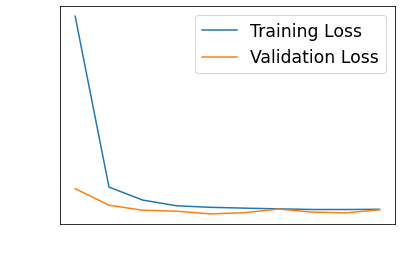

/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/models_evaluation/models_evaluator.py:79: RuntimeWarning: overflow encountered in exp
  new_scoring_func = 2 / (1 + np.exp(np.abs(total_index - absolute_anom_idx) - anom_idx_in_window)) - 1


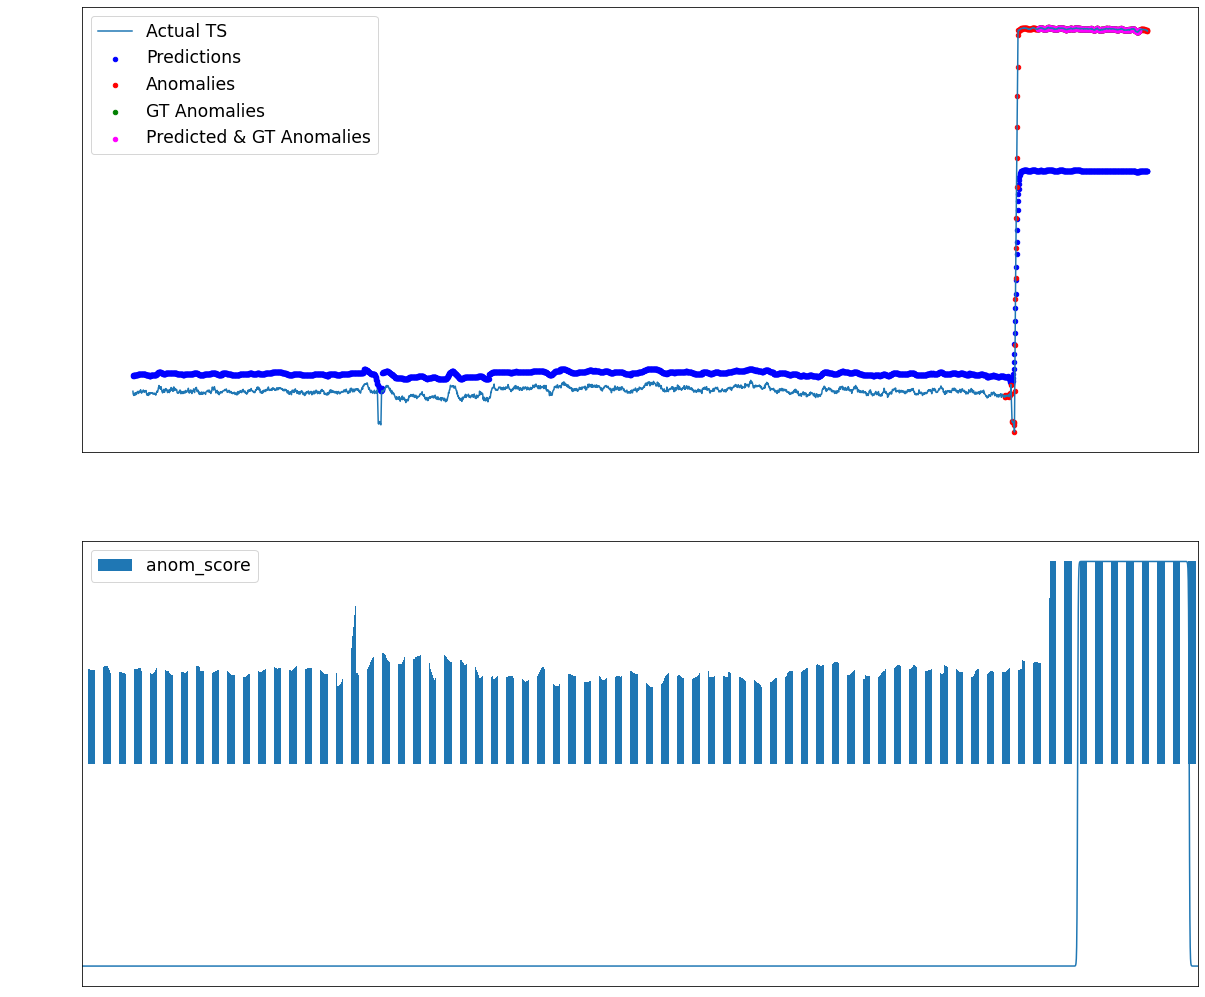

1st:  1.0
2nd:  1.0
3rd:  0.9560529930692448
Customized score:  0.9853509976897482
1st:  1.0
2nd:  1.0
3rd:  0.9560529930692448


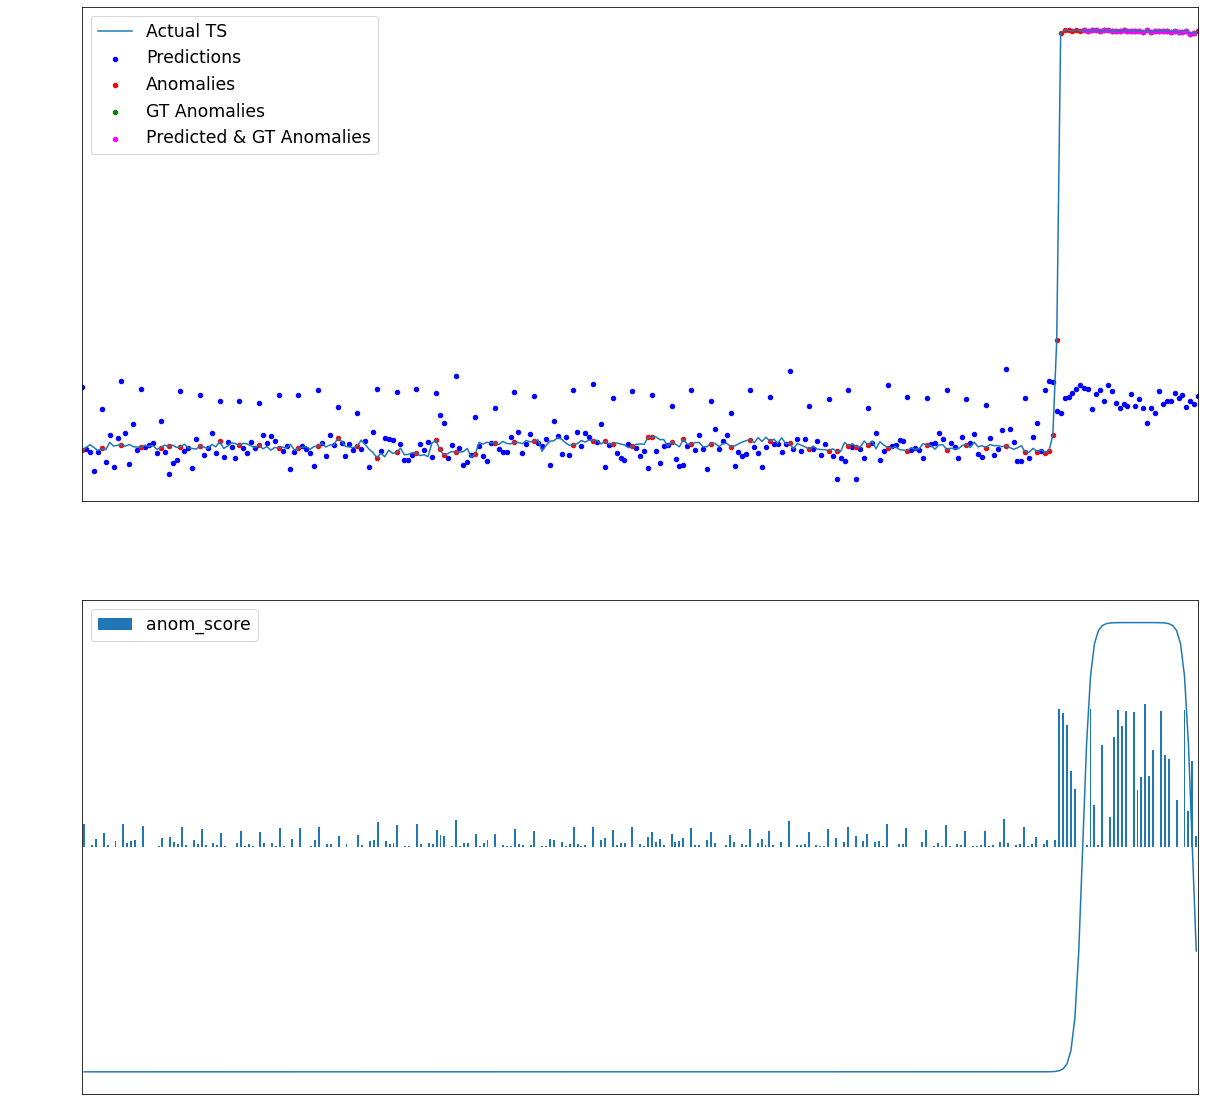

1st:  1.0
2nd:  1.0
3rd:  0.7386051178850381
Customized score:  0.9128683726283461
1st:  1.0
2nd:  1.0
3rd:  0.7386051178850381
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train on 11 samples, validate on 12 samples
Epoch 1/50
11/11 [==============================] - 5s 472ms/step - loss: 0.1567 - val_loss: 0.134

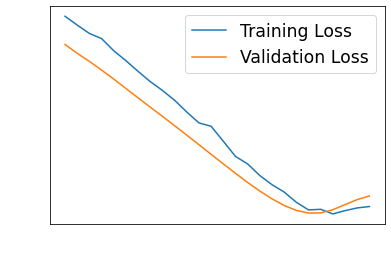

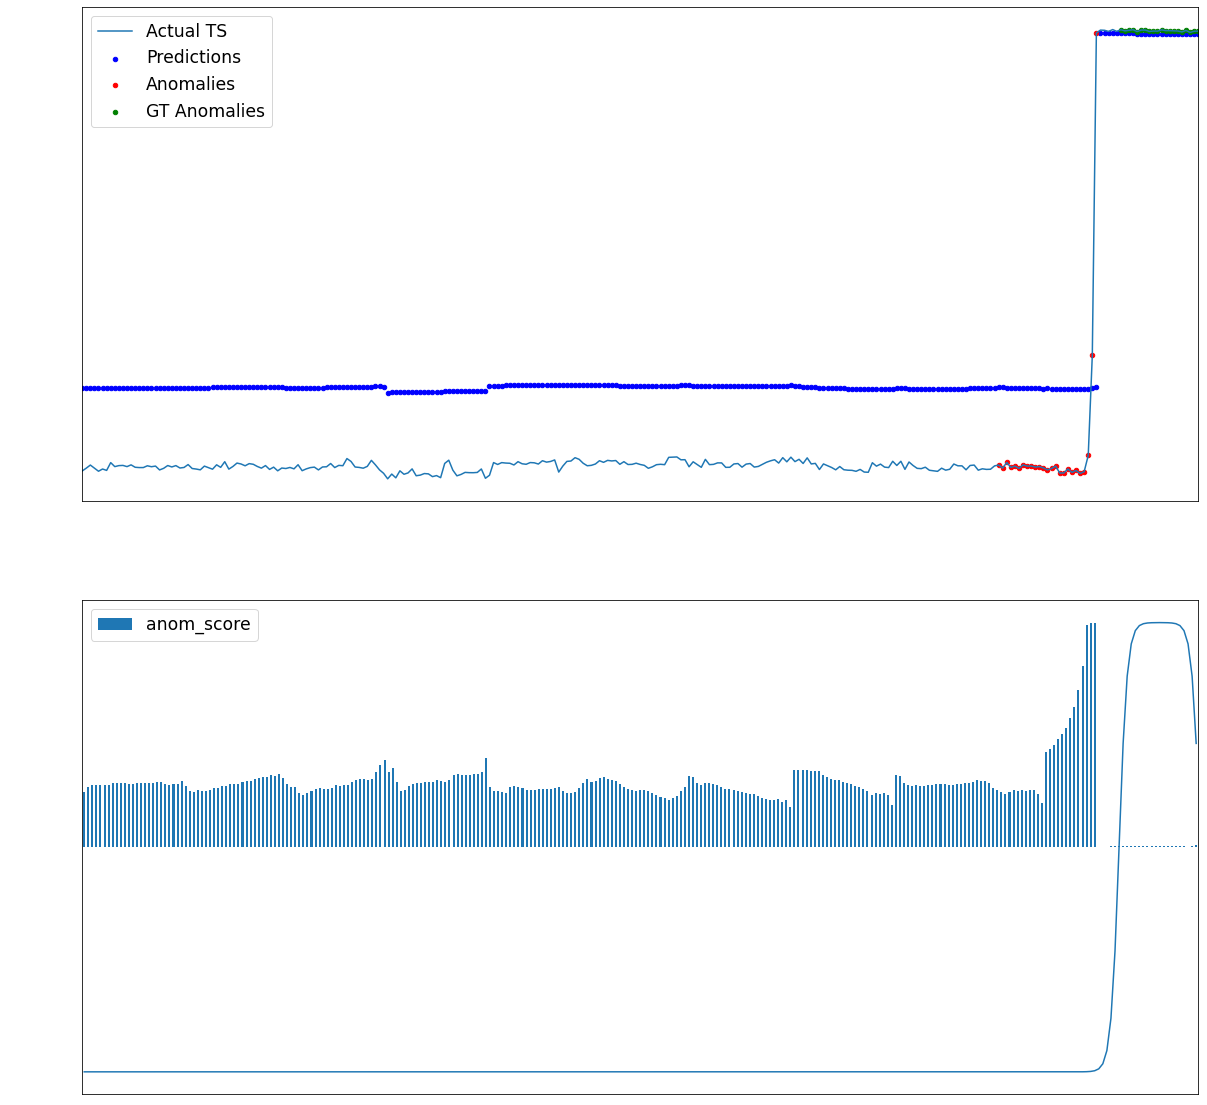

1st:  0.0
2nd:  0.0
3rd:  0.9016333807252473
Customized score:  0.30054446024174913
1st:  0.0
2nd:  0.0
3rd:  0.9016333807252473
1st:  1.0
2nd:  0.5596577097133255
3rd:  0.36666825867643016
Customized score:  0.6421086561299186
1st:  1.0
2nd:  0.5596577097133255
3rd:  0.36666825867643016
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 128)       

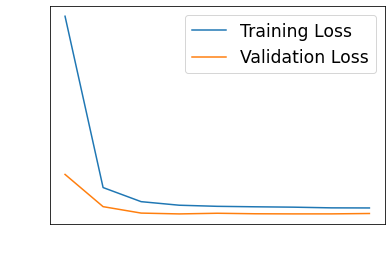

369/369 [==============================] - ETA: 23s - loss: 0.2093 - ETA: 5s - loss: 0.1330  - ETA: 3s - loss: 0.0899 - ETA: 2s - loss: 0.0725 - ETA: 1s - loss: 0.0634 - ETA: 1s - loss: 0.0571 - ETA: 1s - loss: 0.0528 - ETA: 0s - loss: 0.0491 - ETA: 0s - loss: 0.0439 - ETA: 0s - loss: 0.0399 - ETA: 0s - loss: 0.0377

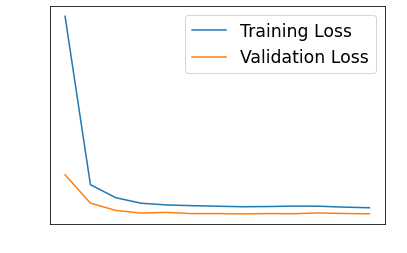

/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/models_evaluation/models_evaluator.py:79: RuntimeWarning: overflow encountered in exp
  new_scoring_func = 2 / (1 + np.exp(np.abs(total_index - absolute_anom_idx) - anom_idx_in_window)) - 1


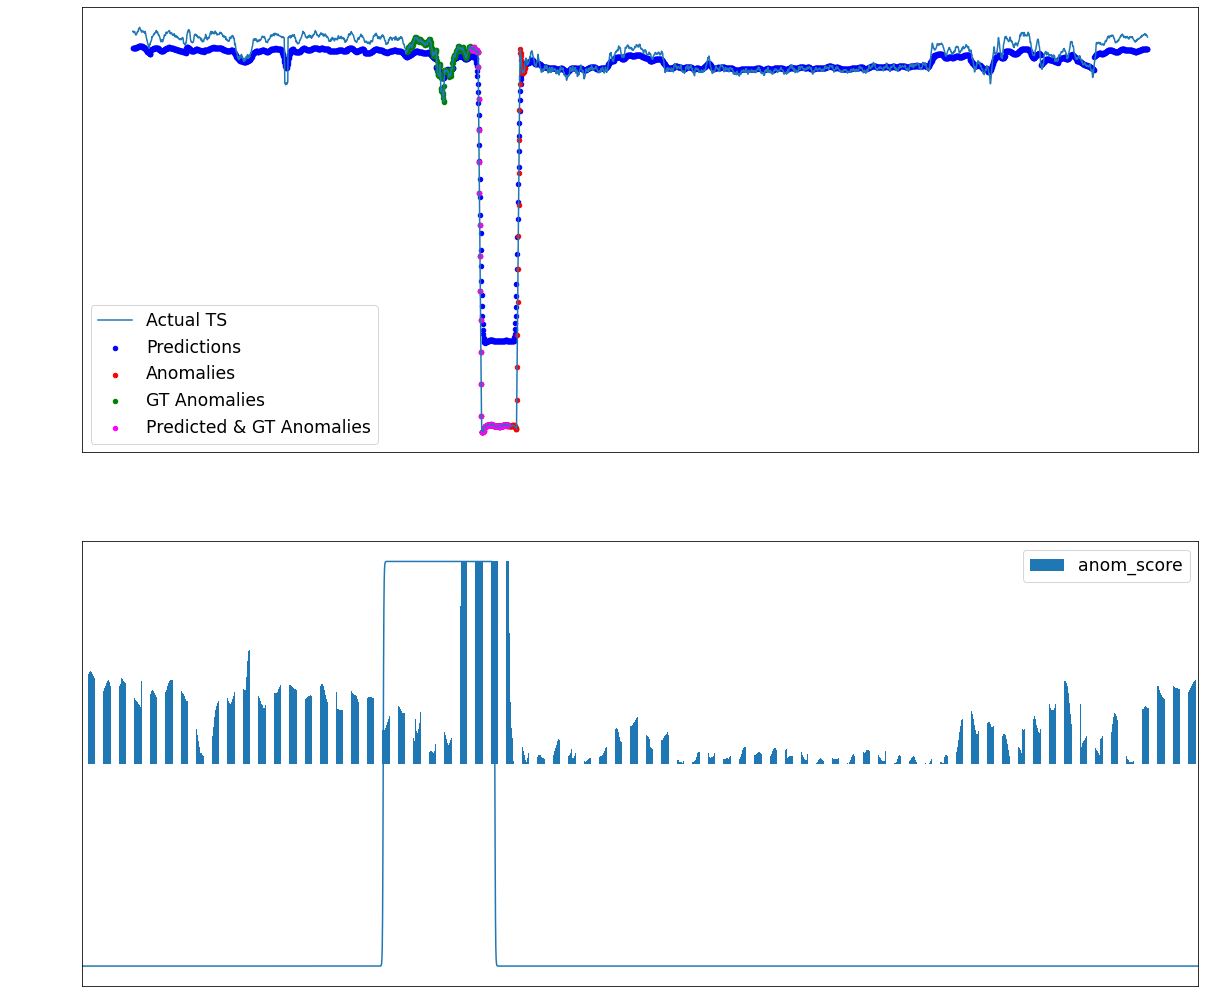

1st:  0.7251461988304093
2nd:  0.36288983535403313
3rd:  0.9824165357885122
Customized score:  0.6901508566576515
1st:  0.7251461988304093
2nd:  0.36288983535403313
3rd:  0.9824165357885122


/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/models_evaluation/models_evaluator.py:79: RuntimeWarning: overflow encountered in exp
  new_scoring_func = 2 / (1 + np.exp(np.abs(total_index - absolute_anom_idx) - anom_idx_in_window)) - 1


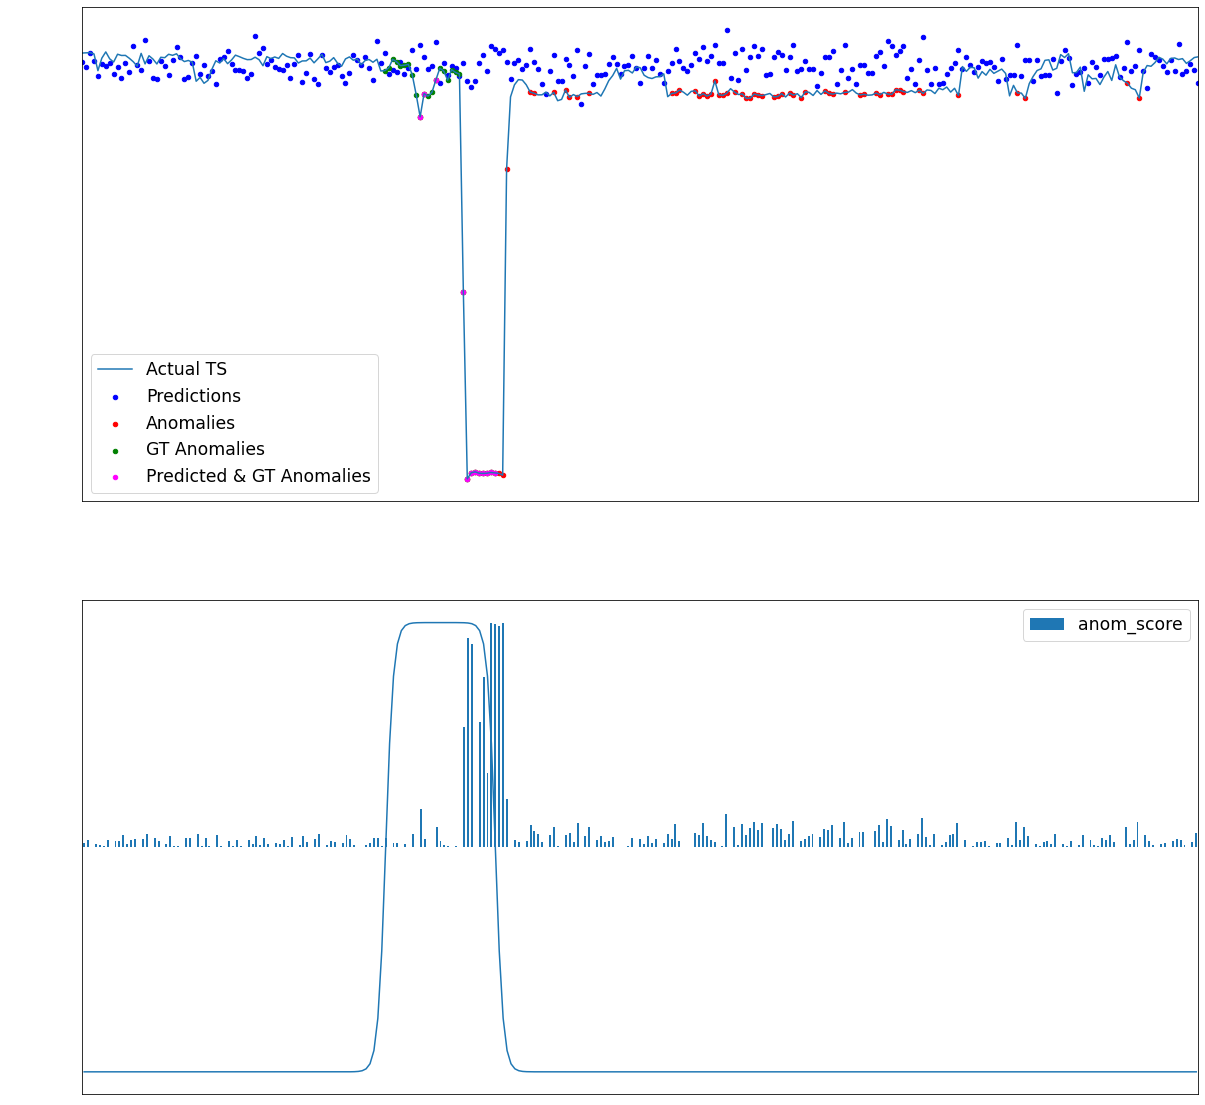

1st:  0.9285714285714286
2nd:  0.40057197933289224
3rd:  0.7830809965782661
Customized score:  0.7040748014941957
1st:  0.9285714285714286
2nd:  0.40057197933289224
3rd:  0.7830809965782661
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train on 11 samples, validate on 12 samples
Epoch 1/50
11/11 [==================

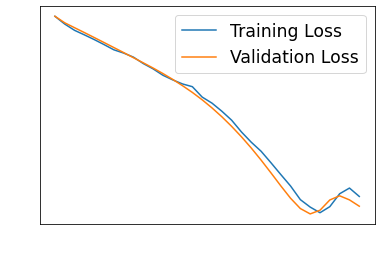

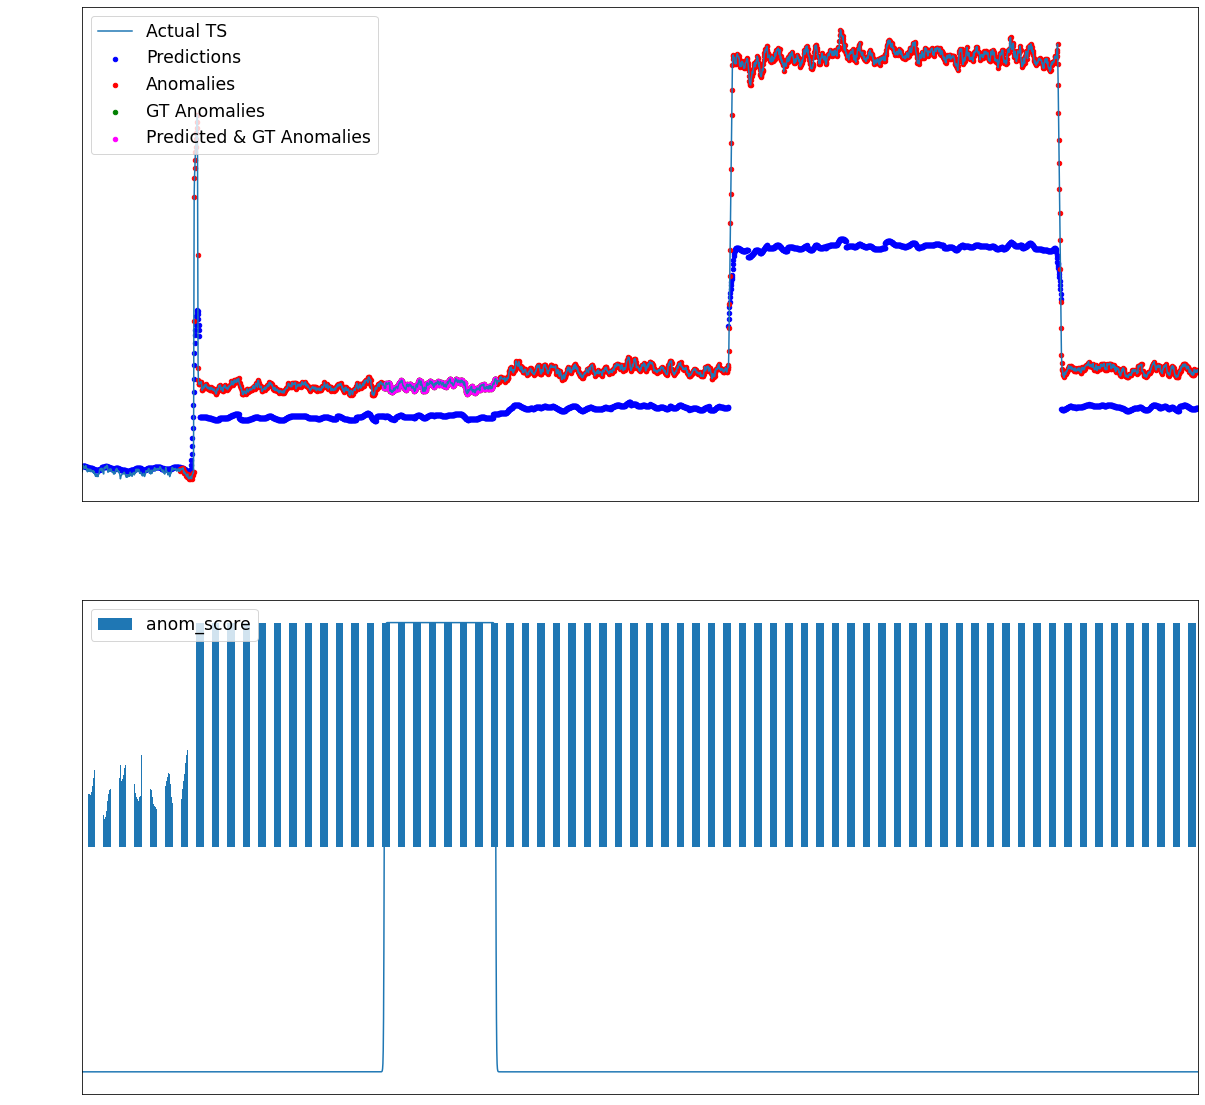

1st:  1.0
2nd:  1.0
3rd:  0.0975564278642087
Customized score:  0.6991854759547363
1st:  1.0
2nd:  1.0
3rd:  0.0975564278642087


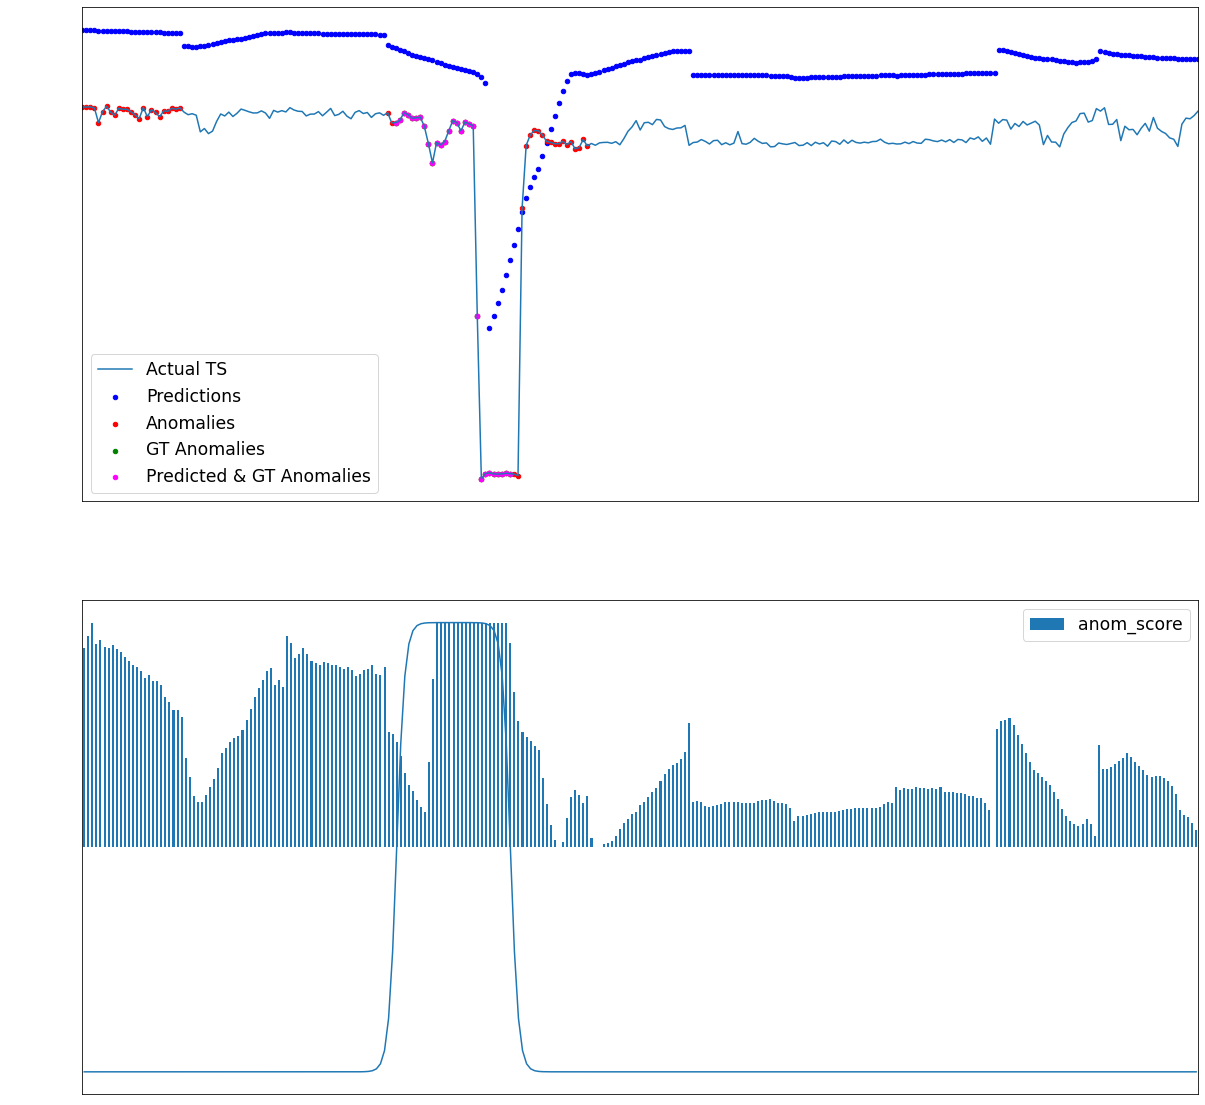

1st:  1.0
2nd:  1.0
3rd:  0.8185681280060239
Customized score:  0.9395227093353413
1st:  1.0
2nd:  1.0
3rd:  0.8185681280060239


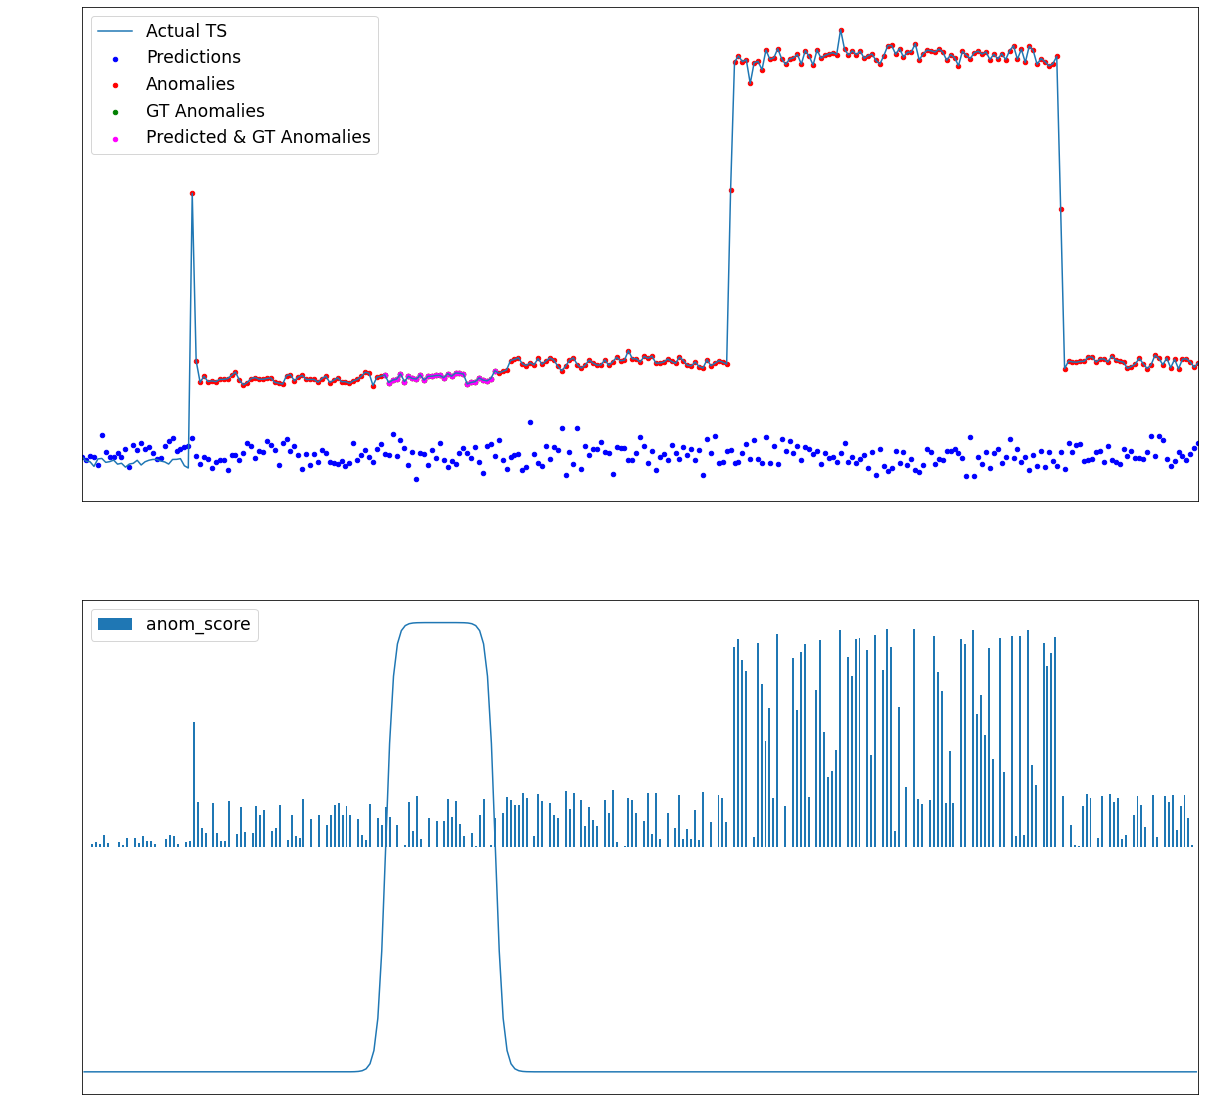

1st:  1.0
2nd:  1.0
3rd:  0.1101740433013183
Customized score:  0.7033913477671061
1st:  1.0
2nd:  1.0
3rd:  0.1101740433013183
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train on 11 samples, validate on 12 samples
Epoch 1/50
11/11 [==============================] - 1s 57ms/step - loss: 6.4887e-04 - val_loss: 3.

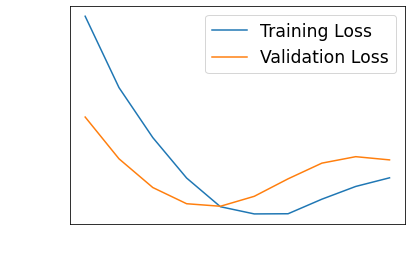

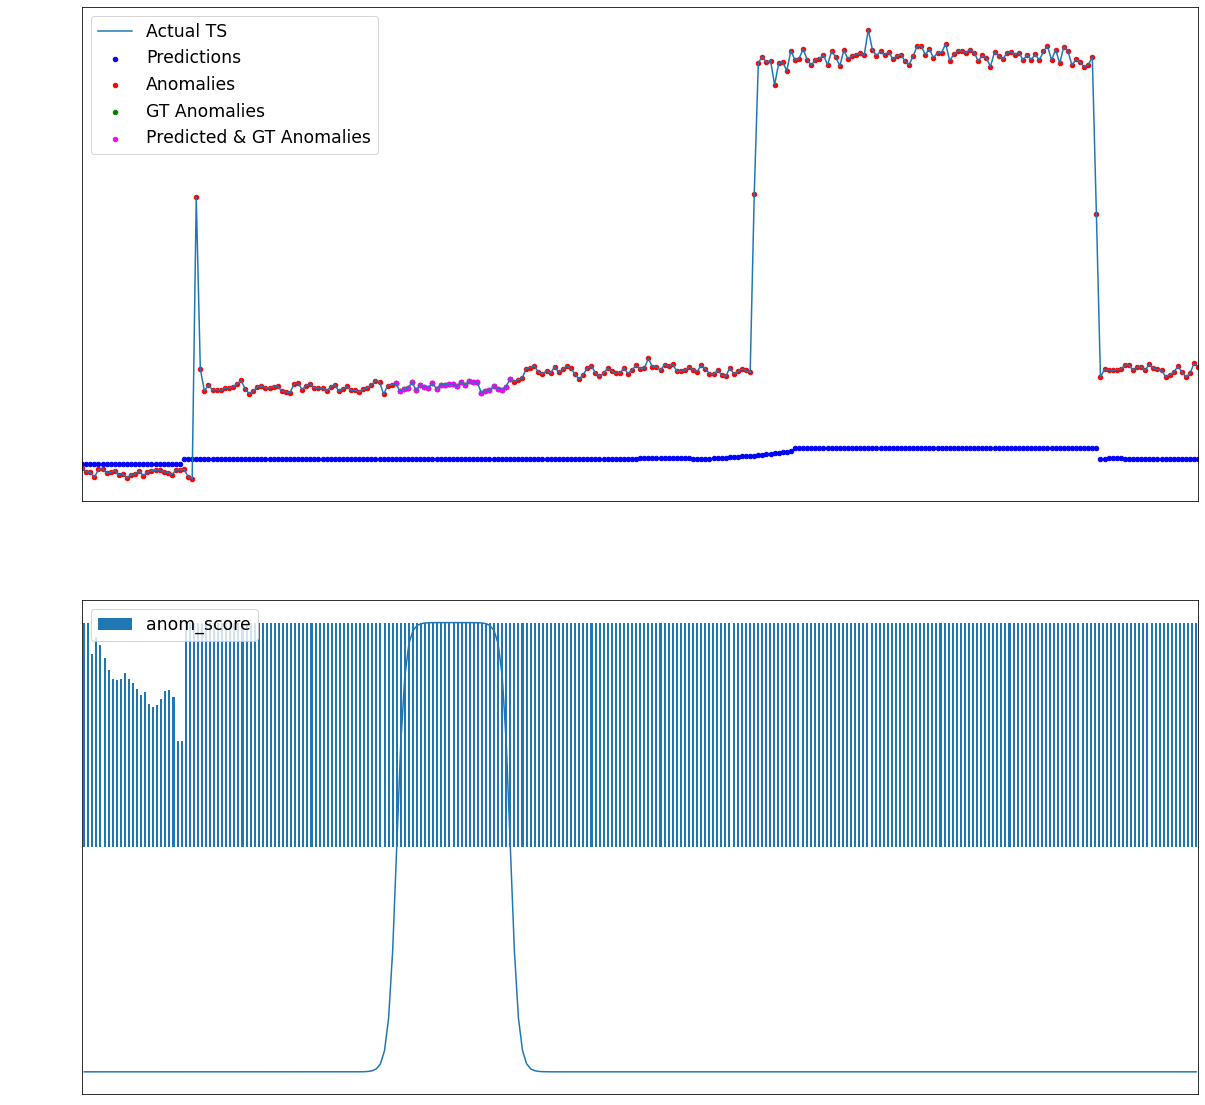

1st:  1.0
2nd:  1.0
3rd:  0.0
Customized score:  0.6666666666666666
1st:  1.0
2nd:  1.0
3rd:  0.0


In [46]:
from typing import Tuple
import concurrent

eval_dict: dict = {}

X_LABEL = "timestamp"
data_dir = "data/archive/"
file_dir = "realAWSCloudwatch"

with open("data/archive/combined_windows.json") as f:
    ground_true_anomalies = json.load(f)

executor = concurrent.futures.ProcessPoolExecutor()


def task_executor(filename: str, original_df: pd.DataFrame, ground_true_anomalies: dict, eval_func):
    file_eval_dict = {}

    true_anomalies_ranges = ground_true_anomalies["/".join(file_path.split("/")[-2:])]
    ground_true_anomalies_df = pd.DataFrame()
    for anom_range in true_anomalies_ranges:
        ground_true_anomalies_df = ground_true_anomalies_df.append(
            original_df.loc[anom_range[0]:anom_range[1]])
    original_df[kad_utils.GROUND_TRUTH_COLUMN] = [idx in ground_true_anomalies_df.index for idx in
                                                  original_df.index.tolist()]

    # SARIMA
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[SARIMA_KEY] = []
    sarima_valid_err, sarima_eval_df = evaluate_sarima(preprocessed_df)
    file_eval_dict[SARIMA_KEY].append(eval_func(sarima_valid_err, sarima_eval_df))

    # AUTOENCODER
    preprocessed_df = original_df.copy()
    preprocessed_df["value"] = preprocessed_df["value"].rolling("h").sum()
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[AUTOENCODER_KEY] = []
    autoenc_valid_err, autoenc_eval_df = evaluate_autoencoder(preprocessed_df)
    file_eval_dict[AUTOENCODER_KEY].append(eval_func(autoenc_valid_err, autoenc_eval_df))

    # HMM
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[HMM_KEY] = []
    hmm_valid_err, hmm_eval_df = evaluate_hmm(preprocessed_df)
    file_eval_dict[HMM_KEY].append(eval_func(hmm_valid_err, hmm_eval_df))

    # LSTM
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[LSTM_KEY] = []
    lstm_valid_err, lstm_eval_df = evaluate_lstm(preprocessed_df)
    file_eval_dict[LSTM_KEY].append(eval_func(lstm_valid_err, lstm_eval_df))

    return filename, file_eval_dict


files_to_eval = ["ec2_cpu_utilization_ac20cd.csv",
                 "rds_cpu_utilization_e47b3b.csv",
                 "ec2_cpu_utilization_825cc2.csv"]

futures_table = list()

for (dirpath, dirnames, filenames) in os.walk(data_dir):
    for filename in filenames:
        if filename in files_to_eval:
            file_path = os.path.join(dirpath, filename)
            original_df = pd.read_csv(file_path, parse_dates=True, index_col="timestamp")
            print("after reading csv")
            futures_table.append(
                executor.submit(task_executor, filename, original_df, ground_true_anomalies,
                                perform_customized_evaluation))

for future in futures_table:
    result: Tuple[str, dict] = future.result()
    eval_dict[result[0]] = result[1]

In [47]:
eval_json = "eval.json"

with open(eval_json, "w") as fp:
    json.dump(eval_dict, fp)

In [48]:
eval_dict

{'ec2_cpu_utilization_825cc2.csv': {'SARIMA': [{'total': 0.6421086561299186,
    'accuracy component': 1.0,
    'collective component': 0.5596577097133255,
    'precision component': 0.36666825867643016}],
  'autoencoder': [{'total': 0.6901508566576515,
    'accuracy component': 0.7251461988304093,
    'collective component': 0.36288983535403313,
    'precision component': 0.9824165357885122}],
  'HMM': [{'total': 0.7040748014941957,
    'accuracy component': 0.9285714285714286,
    'collective component': 0.40057197933289224,
    'precision component': 0.7830809965782661}],
  'LSTM': [{'total': 0.9395227093353413,
    'accuracy component': 1.0,
    'collective component': 1.0,
    'precision component': 0.8185681280060239}]},
 'rds_cpu_utilization_e47b3b.csv': {'SARIMA': [{'total': 0.6666666666666666,
    'accuracy component': 1.0,
    'collective component': 1.0,
    'precision component': 0.0}],
  'autoencoder': [{'total': 0.6991854759547363,
    'accuracy component': 1.0,
    'coll